### Loading of Images

In [7]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

### Hyperparameters

In [8]:
epochs = 20
img_dimensions = (64, 64)
batch_size = 10
learning_rate = 1e-3

### Preprocessing

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = datagen.flow_from_directory(
    data_dir,
    subset="training",
    seed=1337,
    target_size=img_dimensions,
    batch_size=batch_size,
    shuffle=True,
)

val_ds = datagen.flow_from_directory(
    data_dir,
    subset="validation",
    seed=1337,
    target_size=img_dimensions,
    batch_size=batch_size, 
    shuffle=True,
)

Found 788 images belonging to 3 classes.
Found 196 images belonging to 3 classes.


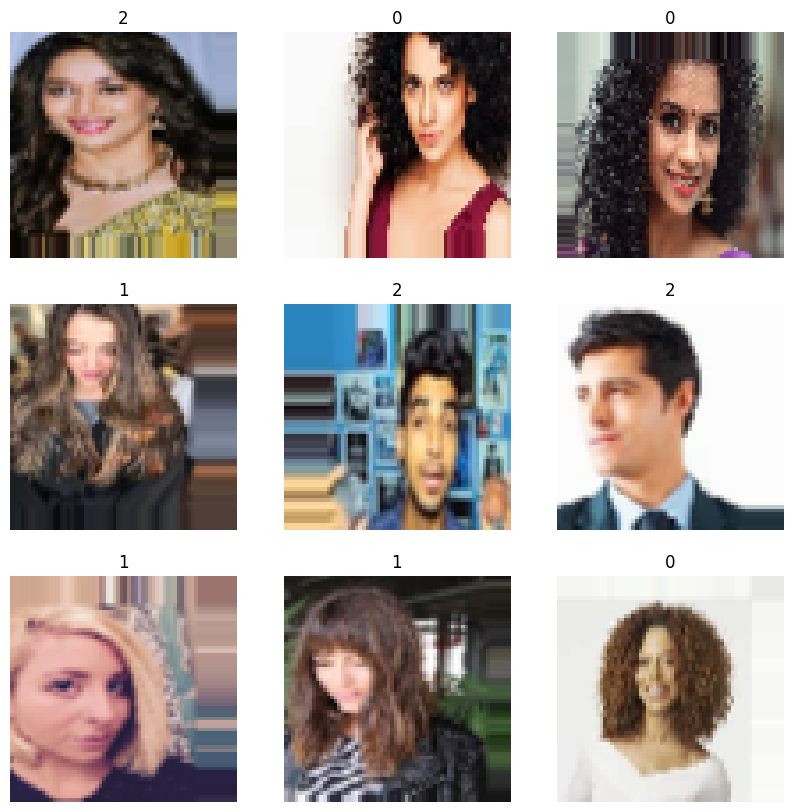

In [10]:
# looking at some sample images
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")
plt.show()

### Modelling

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import pydot as pydot

model = Sequential()
model.add(keras.Input(shape=img_dimensions + (3,))) 
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64))
model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 49, 49, 4)      │         3,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 49, 49, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 8)      │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 42, 42, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 39, 39, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,479 (33.12 KB)

 Trainable params: 8,479 (33.12 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20


KeyboardInterrupt: 

### Visualization 

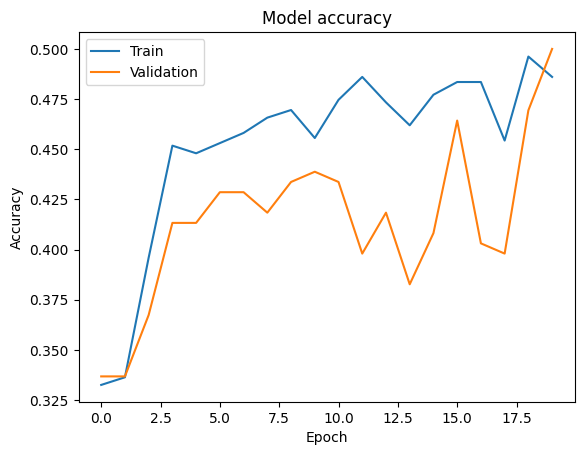

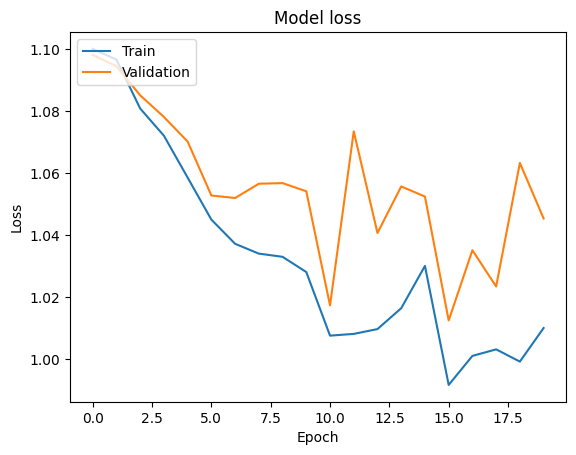

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sample Prediction

In [ ]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=img_dimensions
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
This image is 0.49 percent curly hair, 0.24 percent straight hair, and 0.27 percent wavy hair.
